In [23]:
import keras
import numpy as np

In [24]:

model = keras.saving.load_model("../models/modello-passi.keras")
attivazioni = keras.Model(inputs=model.layers[0].output,outputs=model.layers[6].output)
attivazioni.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 50, 20)         │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 50, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 50, 10)         │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 500)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,730 (10.66 KB)

 Trainable params: 2,730 (10.66 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
import pandas as pd

dati = pd.read_csv("../data/valutati.csv.gz")[:10000]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


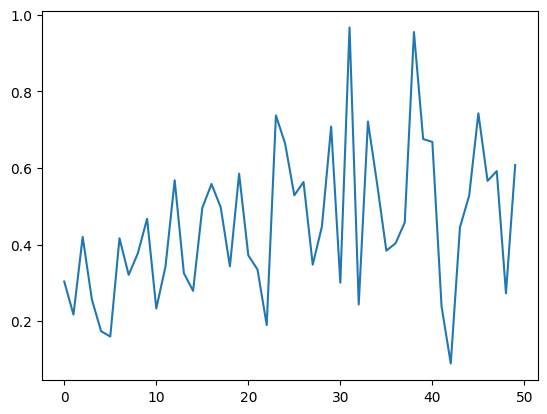

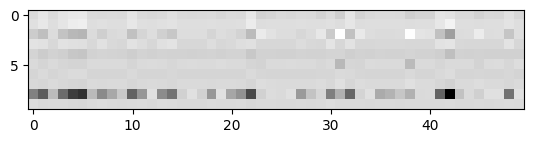

In [18]:
import matplotlib.pyplot as plt

window=50

for uuid,group in dati.groupby('uuid'):
    if len(group)<window:
        continue
    inp = group["user_minmax_steps"].values[-window:].reshape(50,1)
    pred= attivazioni.predict(inp)
    plt.plot(inp, label='Truth')
    plt.show()
    plt.close()
    plt.imshow(pred.reshape(50,10).T,cmap='Greys')
    plt.show()
    plt.close()
    break

In [70]:
import numpy as np

xtrain = []
ytrain = []
xtest=[]
ytest=[]
window=50
test_ratio=0.1
for uuid, group in dati.groupby('uuid')[["user_minmax_steps","sleep_quality_score"]]:
    split=int(len(group)*(1-test_ratio))
    if split<window:
        continue
        
    inputs = np.array(group["user_minmax_steps"].values)
    output = np.array(group["sleep_quality_score"].values)


    for i in range (window,split):
        xtrain.append(inputs[i-window:i])
        ytrain.append(output[i-1])

    for i in range (split,len(group)):
        xtest.append(inputs[i-window:i])
        ytest.append(output[i-1])

xtrain=np.array(xtrain).reshape(-1,window,1)
ytrain=np.array(ytrain).reshape(-1,1)
xtest=np.array(xtest).reshape(-1,window,1)
ytest=np.array(ytest).reshape(-1,1)

In [71]:
attivazioni_train = attivazioni.predict_on_batch(xtrain)
attivazioni_test = attivazioni.predict_on_batch(xtest)

In [72]:
attivazioni_test= attivazioni_test.reshape(-1,500)

attivazioni_train= attivazioni_train.reshape(-1,500)
attivazioni_train

array([[-1.0933929e-02, -1.7137375e-02,  3.1260654e-02, ...,
        -4.9592745e-03,  8.0440372e-02,  1.7502671e-04],
       [ 2.0639170e-03, -9.9277282e-03, -7.6856338e-03, ...,
        -4.4699390e-03, -4.6244994e-02,  1.8731568e-03],
       [-3.0706033e-02, -4.3025907e-02,  5.7592679e-02, ...,
        -3.0572887e-04,  1.6568024e-01, -3.1472787e-03],
       ...,
       [ 5.1805060e-03, -5.3355616e-02,  1.0014719e-01, ...,
         1.5503848e-03,  3.6678109e-01, -1.1942668e-02],
       [ 1.6909970e-02, -5.1324669e-02,  1.0646630e-01, ...,
        -1.1635246e-02,  4.3458521e-01,  3.4176219e-02],
       [-2.8622601e-02, -3.8084384e-02,  5.2732684e-02, ...,
         3.7334003e-03,  2.9320234e-01, -3.1662406e-03]], dtype=float32)

In [91]:
ytest=ytest.reshape(-1)

ytrain=ytrain.reshape(-1)
ytrain

array([0.67738043, 0.58212721, 0.51416949, ..., 0.57828647, 0.48142373,
       0.50064642])

In [92]:
from sklearn.neural_network import MLPRegressor

regressore = MLPRegressor()
regressore.fit(attivazioni_train,ytrain)

MLPRegressor()

In [93]:
regressore.score(attivazioni_test,ytest)

-0.8101652788046323

In [94]:
regressore.predict([attivazioni_test[0]])

array([0.586927], dtype=float32)

In [95]:
ytest[0]

0.2444134615384615